# Fenty Beauty Sentiment Analysis Using Reddit 

## Introduction

In this notebook, we conduct a sentiment analysis on discussions about Fenty Beauty using data collected from Reddit. As a well-known cosmetics brand, Fenty Beauty has sparked a wide range of conversations across online communities, particularly on Reddit. By examining the sentiments within these discussions, we aim to gain insights into how the brand is perceived by users.

## Objectives

The main objectives of this analysis are:
1. **Data Collection and Preprocessing**: To gather and preprocess Reddit posts and comments related to Fenty Beauty from various subreddits, ensuring a comprehensive dataset.
2. **Sentiment Analysis**: To analyze sentiments expressed in the data using two models—first with VADER (Valence Aware Dictionary and sEntiment Reasoner) and then wDistilBert Roberta model, comparing results to deepen our understanding.
3. **Visualization of Sentiment Distribution**: To create visualizations that show the distribution of sentiments, providing an overview of how Reddit users generally feel about Fenty Beauty.
4. **Word Cloud and Adjective Analysis**: To generate word clouds and other visual tools that reveal the most commonly used words and adjectives, highlighting themes and popular opinions within the discussions. 

This analysis will help us uncover key sentiment trends and frequently mentioned topics related to Fenty Beauty, offering valuable insights into the brand's reputation among Reddit users.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import tensorflow as tf
import re
import os
from wordcloud import WordCloud
import seaborn as sns



In [9]:
import praw

# Create a Reddit instance
reddit = praw.Reddit(
    client_id='yg1PDhNmGMT6dUfiO4Enfw',
    client_secret='TRQzc_gVK4y5x7ViQXaohcNMuYbRag',
    user_agent='fenty_analysis by /u/Beginning_Type_4221'
)



## Data Collection

We will be collecting data from the following subreddit:
- `Makeup`

We can add subreddits to explore later on.

The data collection process involves searching for posts that mention "Fenty Beauty" and extracting relevant comments. We will focus on comments that provide meaningful feedback and exclude non-relevant responses.



In [3]:
subreddit = reddit.subreddit("Makeup")
posts = subreddit.search("Fenty Beauty", limit=200)

fenty_reviews = []

# Keywords to exclude non-relevant comments
exclude_keywords = ["thank", "thanks", "you're welcome"]

for post in posts:
     if "fenty beauty" in post.title.lower() :
            post.comments.replace_more(limit=None)
            for comment in post.comments.list():
                if not any(keyword in comment.body.lower() for keyword in exclude_keywords):
                    fenty_reviews.append({
                        'subreddit': subreddit,
                        'post_title': post.title,
                        'comment': comment.body
                    })
for review in fenty_reviews:
    print(review)


{'subreddit': Subreddit(display_name='Makeup'), 'post_title': "What's everyone's thoughts on Fenty Beauty? ", 'comment': 'I find their foundations too orange for me and they oxidize a lot unfortunately.'}
{'subreddit': Subreddit(display_name='Makeup'), 'post_title': "What's everyone's thoughts on Fenty Beauty? ", 'comment': 'A nightmare for dry and sensitive skin.'}
{'subreddit': Subreddit(display_name='Makeup'), 'post_title': "What's everyone's thoughts on Fenty Beauty? ", 'comment': "Appropriately hyped imo, I know so many people who could not find their shade until Fenty released. I really like their Eaze drops, hydrating foundation, and contour sticks. They have one highlighter that's worth it to me. The killawatt.\xa0"}
{'subreddit': Subreddit(display_name='Makeup'), 'post_title': "What's everyone's thoughts on Fenty Beauty? ", 'comment': "Not great. Don't like the gloss, matte foundation, or highlighter duos."}
{'subreddit': Subreddit(display_name='Makeup'), 'post_title': "What's

In [10]:

output_path = '../reviews/fenty_reviews.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df = pd.DataFrame(fenty_reviews)
df.to_csv(output_path, index=False)

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing to all comments



[nltk_data] Downloading package punkt to C:\Users\Jihane
[nltk_data]     bis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jihane
[nltk_data]     bis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df2 = df

In [12]:
print('Before preprocessing \n', df['comment'][2])

df['comment'] = df['comment'].apply(preprocess_text)

print('After preprocessing \n', df['comment'][2])

Before preprocessing 
 Appropriately hyped imo, I know so many people who could not find their shade until Fenty released. I really like their Eaze drops, hydrating foundation, and contour sticks. They have one highlighter that's worth it to me. The killawatt. 
After preprocessing 
 appropriately hyped imo i know so many people who could not find their shade until fenty released i really like their eaze drops hydrating foundation and contour sticks they have one highlighter thats worth it to me the killawatt 


# Sentiment Analysis

## Using Vader

We will use the VADER model from the `nltk` library for sentiment analysis. VADER is well-suited for social media texts as it can handle emoticons, slang, and other nuances commonly found in such platforms. The sentiment scores will be categorized as:
- **Positive**
- **Negative**
- **Neutral**

## Visualizations

To gain a deeper understanding of the sentiments, we will create various visualizations, including:
- Histograms of sentiment polarity scores
- Word clouds of all words and adjectives
- Sentiment distribution bar plots
- Scatter plots of sentiment polarity vs. subjectivity ( for other models than vader)

These visualizations will help us identify the most common sentiments and the key attributes being discussed in relation to Fenty Beauty.



In [53]:

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to C:\Users\Jihane
[nltk_data]     bis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
# Function to calculate VADER sentiment
def vader_sentiment(text):
    return sia.polarity_scores(text)

# Perform sentiment analysis on cleaned text
for review in fenty_reviews:
    text = review['post_title'] + ' ' + review['comment']
    sentiment_scores = vader_sentiment(text)
    review['compound'] = sentiment_scores['compound']
    review['pos'] = sentiment_scores['pos']
    review['neu'] = sentiment_scores['neu']
    review['neg'] = sentiment_scores['neg']

# Create a DataFrame for analysis
df = pd.DataFrame(fenty_reviews)


In [55]:
df

,subreddit,post_title,comment,compound,pos,neu,neg
0,Makeup,What's everyone's thoughts on Fenty Beauty?,I find their foundations too orange for me and...,0.3400,0.171,0.721,0.108
1,Makeup,What's everyone's thoughts on Fenty Beauty?,A nightmare for dry and sensitive skin.,0.5859,0.257,0.743,0.000
2,Makeup,What's everyone's thoughts on Fenty Beauty?,"Appropriately hyped imo, I know so many people...",0.8173,0.175,0.825,0.000
3,Makeup,What's everyone's thoughts on Fenty Beauty?,"Not great. Don't like the gloss, matte foundat...",0.3242,0.245,0.611,0.144
4,Makeup,What's everyone's thoughts on Fenty Beauty?,The eyeliners suck for me. Slightly hooded and...,0.8733,0.272,0.619,0.109
...,...,...,...,...,...,...,...
708,Makeup,Has anyone tried the new Fenty Beauty Holiday ...,I wanted most of it before I started reading a...,0.8883,0.196,0.720,0.085
709,Makeup,Has anyone tried the new Fenty Beauty Holiday ...,I got both lipstick sets - They are absolutely...,0.9652,0.238,0.740,0.022
710,Makeup,"Ok ladies, for those of you that have already ...",Every tutorial I've seen shows much better cov...,0.6996,0.152,0.795,0.053
711,Makeup,"Ok ladies, for those of you that have already ...",I haven't tried the brush yet but I've found t...,0.7717,0.152,0.799,0.049


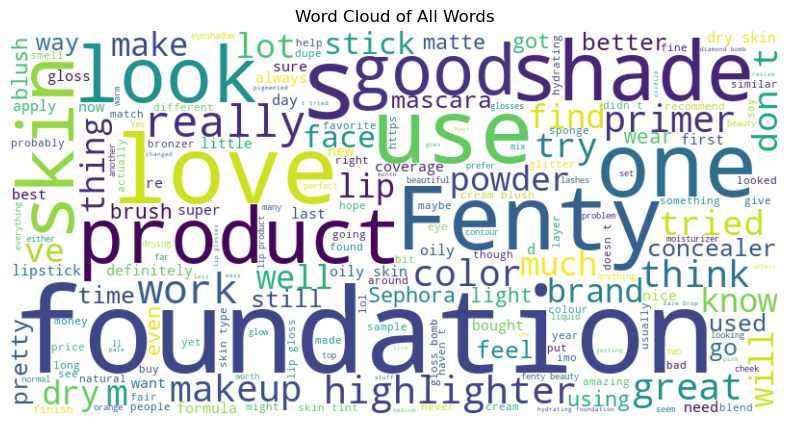

In [56]:
all_text = ' '.join(df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Words')
plt.show()


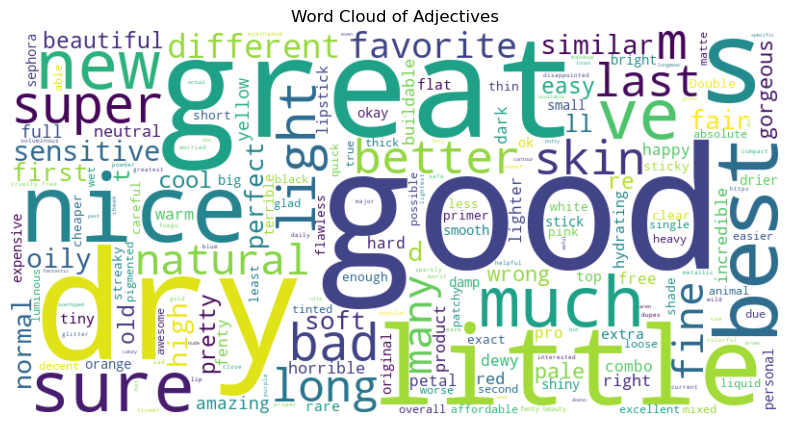

In [51]:
def extract_adjectives(text):
    words = word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    adjectives = [word for word, tag in tagged_words if tag in ('JJ', 'JJR', 'JJS')]
    return ' '.join(adjectives)

all_adjectives = ' '.join(df['comment'].apply(extract_adjectives))

wordcloud_adjectives = WordCloud(width=800, height=400, background_color='white').generate(all_adjectives)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_adjectives, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Adjectives')
plt.show()


### Interpretation of Word Clouds for Fenty Beauty

The word clouds provide a visual representation of the most frequently mentioned words and adjectives in Reddit comments about Fenty Beauty. Here's what they indicate:

#### Word Cloud of All Words

1. **Prominent Words**:
   - **Foundation**: This word appears most frequently, suggesting that Fenty Beauty's foundation products are a major topic of discussion among users.
   - **Shade**: Indicates that users are often talking about the variety of shades available, which aligns with Fenty Beauty's reputation for inclusivity.
   - **Skin**: Reflects the importance of skin compatibility and concerns related to different skin types.
   - **Love**: A strong positive word, showing that many users express affection and positive feelings towards the brand.
   - **Primer, Product, Use, Good, Really, One**: These words suggest discussions about product usability, effectiveness, and specific product recommendations.

2. **Contextual Insights**:
   - The prominence of words like "shade," "skin," and "foundation" highlights Fenty Beauty's strong association with inclusive and high-quality foundation products.
   - Positive words like "love" and "good" suggest a generally favorable perception of the brand.

#### Word Cloud of Adjectives

1. **Prominent Adjectives**:
   - **Good, Great, Nice, Best**: These adjectives indicate positive sentiments towards Fenty Beauty products.
   - **Dry**: This could be a point of concern or a feature of certain products, suggesting users talk about how certain products work with dry skin.
   - **Little, Much, New**: These adjectives provide context about user experiences, whether they need a little or a lot of product, and discussions about new releases.
   - **Natural**: Indicates a preference or comment about products that give a natural look.
   - **Sensitive, Light, Long**: Reflects considerations about skin sensitivity, product weight, and longevity.

2. **Contextual Insights**:
   - The prevalence of positive adjectives like "good," "great," and "nice" reinforces the positive sentiment observed in the sentiment analysis.
   - The adjective "dry" might indicate a specific skin type issue that users are discussing, which could be either positive (e.g., good for dry skin) or negative (e.g., makes skin feel dry).
   - Words like "natural" and "sensitive" suggest that users value products that cater to natural looks and sensitive skin.

The word clouds highlight key aspects of Fenty Beauty that are most discussed by users. The overall positive sentiment is reinforced by frequent positive adjectives. The focus on foundation and shade diversity aligns with the brand's emphasis on inclusivity. However, there are also mentions of specific concerns like "dry" which could be areas for the brand to address.



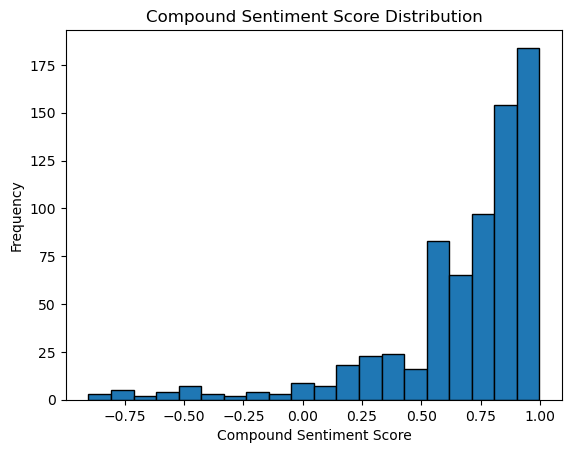

In [45]:
plt.hist(df['compound'], bins=20, edgecolor='black')
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()


D:\Users\Jihane bis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


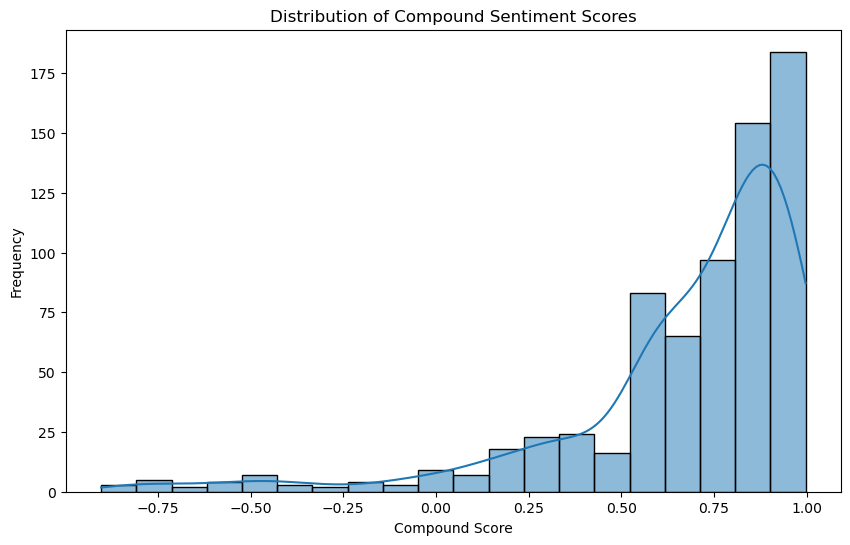

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(df['compound'], bins=20, kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()


The compound sentiment score distribution underscores a predominantly positive perception of Fenty Beauty within the Reddit community. 

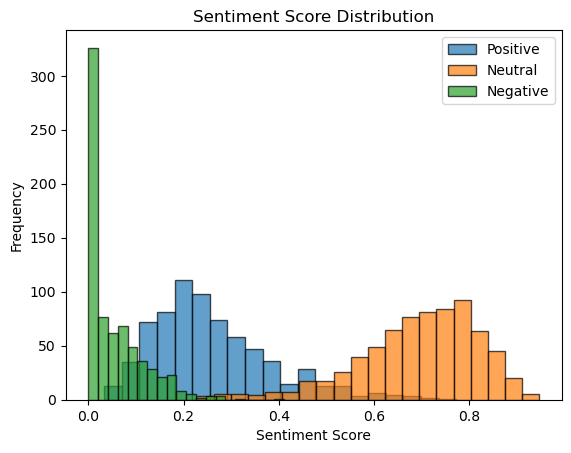

In [47]:
plt.hist(df['pos'], bins=20, edgecolor='black', alpha=0.7, label='Positive')
plt.hist(df['neu'], bins=20, edgecolor='black', alpha=0.7, label='Neutral')
plt.hist(df['neg'], bins=20, edgecolor='black', alpha=0.7, label='Negative')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [61]:
# Categorize sentiment based on the compound score
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply categorization function to create 'sentiment_category' column
df['sentiment_category'] = df['compound'].apply(categorize_sentiment)


# Extract positive comments
positive_comments = df[df['sentiment_category'] == 'Positive']

# Extract neutral comments
neutral_comments = df[df['sentiment_category'] == 'Neutral']

# Extract negative comments
negative_comments = df[df['sentiment_category'] == 'Negative']
def print_comment_samples(comments_df, sentiment_label, num_samples=3):
    print(f"\nExamples of {sentiment_label} Comments:")
    for i in range(min(num_samples, len(comments_df))):
        print(f"\nComment {i+1}:")
        print(comments_df.iloc[i]['comment'])

# Print examples
print_comment_samples(positive_comments, 'Positive', num_samples=3)
print_comment_samples(neutral_comments, 'Neutral', num_samples=3)
print_comment_samples(negative_comments, 'Negative', num_samples=3)


Examples of Positive Comments:

Comment 1:
I find their foundations too orange for me and they oxidize a lot unfortunately.

Comment 2:
A nightmare for dry and sensitive skin.

Comment 3:
Appropriately hyped imo, I know so many people who could not find their shade until Fenty released. I really like their Eaze drops, hydrating foundation, and contour sticks. They have one highlighter that's worth it to me. The killawatt. 

Examples of Neutral Comments:

Comment 1:
Their glosses are too die for, I haven’t used much else from it

Comment 2:
I have found everything to be “fine.” But not worthwhile. Other brands have products that I would rather spend my money one wether it be cheaper or not

Comment 3:
This has happened to me many times if it's a pump you'll be fine if product is exposed you can wrap in plastic wrap or keep in a zip lock baggy

Examples of Negative Comments:

Comment 1:
I think that Fenty is way overhyped. I've tried their cream blush that I liked initially but it went 

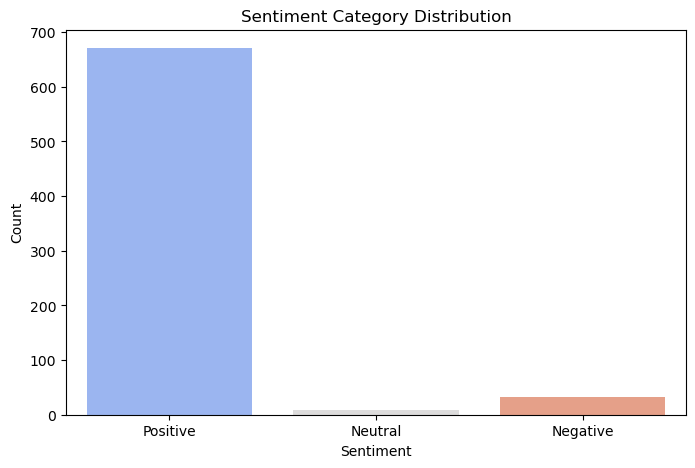

In [62]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_category', data=df, palette='coolwarm')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


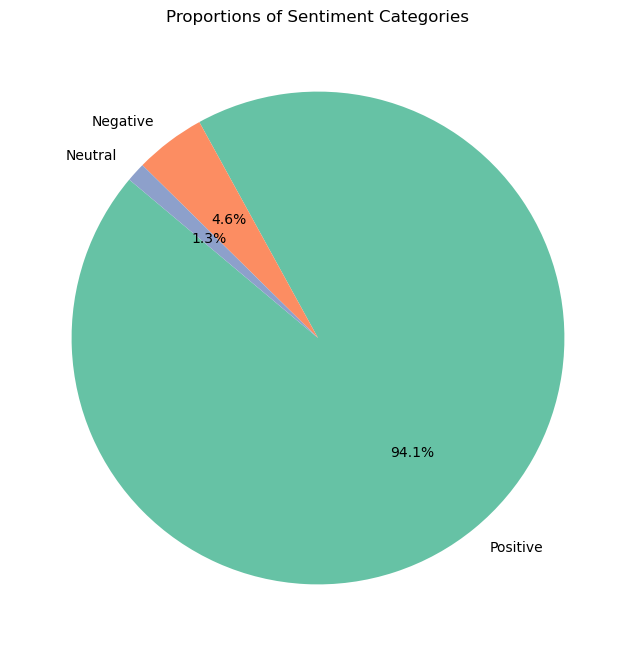

In [63]:

sentiment_counts = df['sentiment_category'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Proportions of Sentiment Categories')
plt.show()


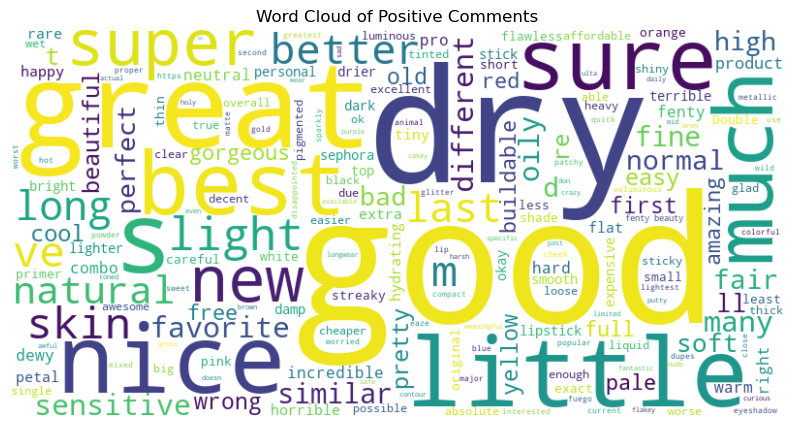

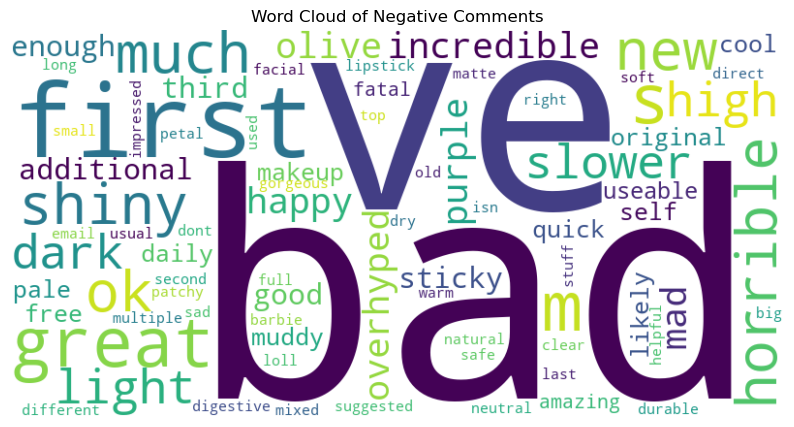

In [64]:

positive_text = ' '.join(df[df['compound'] > 0.05]['comment'].apply(extract_adjectives))

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Comments')
plt.show()


negative_text = ' '.join(df[df['compound'] < -0.05]['comment'].apply(extract_adjectives))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Comments')
plt.show()


### Observation

We notice that vader mistakes some comments for positive and other for negative and that is caused by its inability to work in context , phrases like : **A nightmare for dry and sensitive skin** are negative but have been classified as positive 

iews

### Overview

We used the VADER sentiment analysis model to examine Reddit comments about Fenty Beauty products. VADER, designed for social media and online reviews, provides four scores for each comment:
- **Compound**: An overall sentiment score from -1 (most negative) to 1 (most positive).
- **Positive**, **Neutral**, **Negative**: These scores show the proportions of each sentiment within the text.

Based on the compound score, we classified each comment as **Positive**, **Neutral**, or **Negative** to better understand how people feel about Fenty Beauty.

### Key Observations and Insights

1. **Sentiment Score Distribution**:
   - The distribution of sentiment scores shows a large cluster around neutral scores, suggesting that many users shared balanced or factual feedback without strong opinions.
   - Positive scores were especially common, particularly in the 0.2 to 0.8 range, indicating that many users have favorable impressions.
   - Negative scores were less frequent, suggesting that criticisms of Fenty Beauty products, while present, are relatively uncommon.

2. **Sentiment Category Distribution**:
   - Most comments fell into the **Positive** category, showing that users generally feel favorably toward Fenty Beauty.
   - A smaller number of comments were **Neutral**, with users offering balanced or factual feedback without strong sentiments.
   - **Negative** comments were the rarest, indicating that while there are criticisms, they don’t dominate the discussion.

3. **Word Cloud Analysis**:
   - For negative comments, words like "bad," "horrible," and "overhyped" were common. These highlight specific issues users have with product performance or packaging.

### Interpretation

- **Positive Reception**:
   - The analysis shows that users generally have a positive perception of Fenty Beauty, often praising the brand's unique shade range, product quality, and iconic items like the "Killawatt" highlighter.

- **Neutral Sentiments**:
   - Neutral comments suggest that some customers find Fenty Beauty products satisfactory but not remarkable. They tend to share observations that are practical, without strong likes or dislikes.

- **Negative Sentiments**:
   - Negative feedback often mentions issues like foundation shades that are “too orange,” skin reactions, and leaks in product packaging. Although these comments are less frequent, they point to areas where users think improvements could be made.

### Model Critique

#### Strengths of VADER

1. **Efficiency**: VADER is quick and computationally light, which makes it great for processing large amounts of text data in a short time.
2. **Adapted for Social Media**: It’s well-suited for social media and online reviews, where informal language, slang, abbreviations, and even emoticons are common.
3. **Reliable for Clear Sentiment**: For straightforward comments that are clearly positive or negative, VADER generally performs well, giving us a rough but useful sentiment overview.

#### Limitations of VADER

1. **Struggles with Nuance**:
   - VADER relies on a lexicon with predefined word scores, which means it can miss the subtlety in comments. For example, a comment like *“I wanted to love it, but it just didn’t work for me”* may carry mixed feelings that VADER might not capture accurately.

2. **Context Issues**:
   - Words like "heavy" can have different meanings depending on the context. In makeup reviews, "heavy" could be good or bad, but VADER may misinterpret it based on its lexicon scores. Similarly, phrases like *“too orange”* in a foundation review might not get recognized as negative if “orange” isn’t tagged as negative in VADER’s dictionary.

3. **Limited Lexicon**:
   - VADER doesn’t always handle industry-specific language well. For instance, “oxidize” is a common term in makeup that describes how foundation changes color after application, often critically. VADER might not recognize it as negative, even though it’s often used that way in makeup discussions.

4. **Difficulty with Complex Sentences**:
   - VADER doesn’t handle sentences with mixed sentiments very well. For example, *“The gloss is amazing, but the foundation made me break out”* could be confusing for VADER, which may struggle to balance the positive and negative parts of the comment.

5. **Simple Thresholds for Categorization**:
   - Using fixed thresholds (e.g., compound score > 0.05 for positive) can be simplistic. Comments near the threshold may convey a weak sentiment, but VADER might categorize them as neutral, potentially missing subtle positivity or negativity.

### Conclusion

VADER gives us a generally positive picture of Fenty Beauty, with specific areas for improvement—especially around product packaging and skin compatibility. While VADER is effective for a quick overview, it has its limitations in understanding nuanced and context-dependent sentiments. For a brand-focused analysis where subtle customer feedback is valuable, a more advanced or hybrid approach could offer deeper insights.

This analysis provides a solid foundation, but addressing VADER’s limitationsif you'd like further tweaks to make it even more engaging or accessible!

In [65]:
df = df2

In [67]:
from transformers import pipeline
import pandas as pd

# Load the sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True)


def analyze_sentiment(text):
    # Tokenize and truncate at 512 tokens directly within the pipeline
    result = sentiment_model(text, truncation=True, max_length=512)[0]
    return result['label'], result['score']

df[['transformer_sentiment', 'transformer_score']] = df['comment'].apply(lambda x: pd.Series(analyze_sentiment(x)))


In [68]:
df

,subreddit,post_title,comment,comment_truncated,transformer_sentiment,transformer_score
0,Makeup,What's everyone's thoughts on Fenty Beauty?,i find their foundations too orange for me and...,i find their foundations too orange for me and...,NEGATIVE,0.999756
1,Makeup,What's everyone's thoughts on Fenty Beauty?,a nightmare for dry and sensitive skin,a nightmare for dry and sensitive skin,NEGATIVE,0.984211
2,Makeup,What's everyone's thoughts on Fenty Beauty?,appropriately hyped imo i know so many people ...,appropriately hyped imo i know so many people ...,POSITIVE,0.997712
3,Makeup,What's everyone's thoughts on Fenty Beauty?,not great dont like the gloss matte foundation...,not great dont like the gloss matte foundation...,NEGATIVE,0.999558
4,Makeup,What's everyone's thoughts on Fenty Beauty?,the eyeliners suck for me slightly hooded and ...,the eyeliners suck for me slightly hooded and ...,POSITIVE,0.625654
...,...,...,...,...,...,...
708,Makeup,Has anyone tried the new Fenty Beauty Holiday ...,i wanted most of it before i started reading a...,i wanted most of it before i started reading a...,NEGATIVE,0.999554
709,Makeup,Has anyone tried the new Fenty Beauty Holiday ...,i got both lipstick sets they are absolutely ...,i got both lipstick sets they are absolutely b...,POSITIVE,0.999782
710,Makeup,"Ok ladies, for those of you that have already ...",every tutorial ive seen shows much better cove...,every tutorial ive seen shows much better cove...,NEGATIVE,0.992835
711,Makeup,"Ok ladies, for those of you that have already ...",i havent tried the brush yet but ive found the...,i havent tried the brush yet but ive found the...,POSITIVE,0.996033


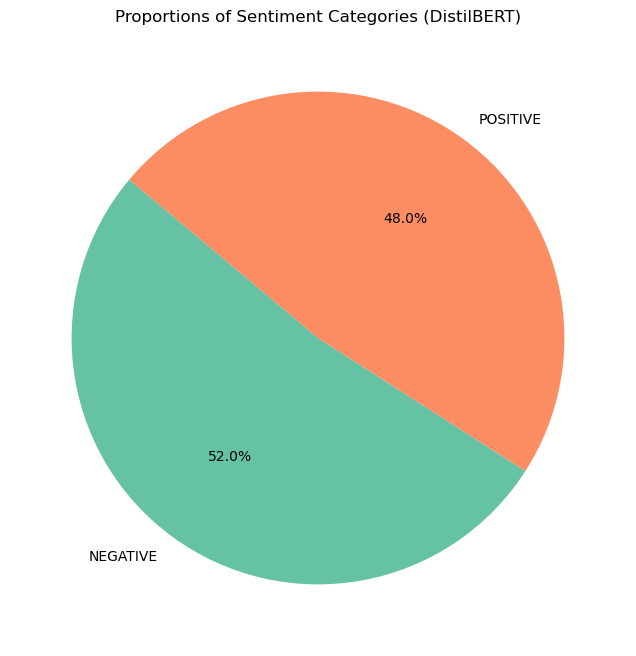

In [69]:

sentiment_counts = df['transformer_sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Proportions of Sentiment Categories (DistilBERT)')
plt.show()


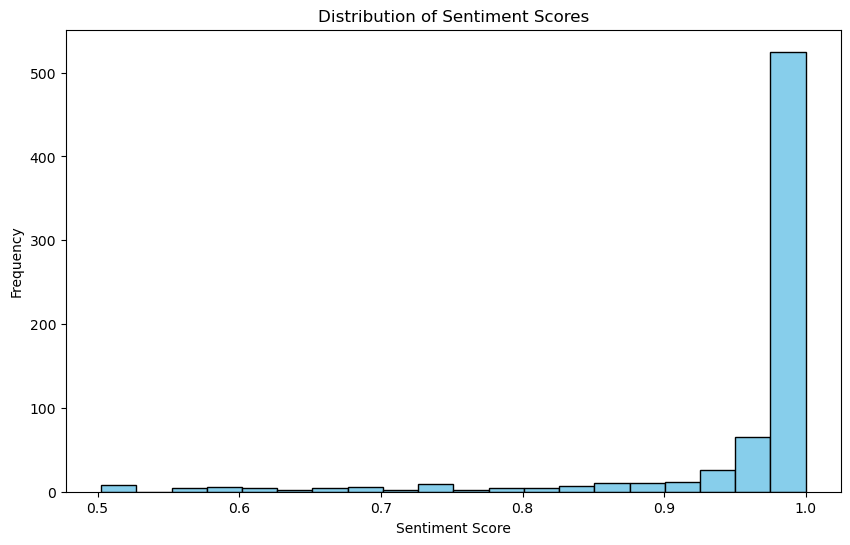

In [70]:

plt.figure(figsize=(10, 6))
plt.hist(df['transformer_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


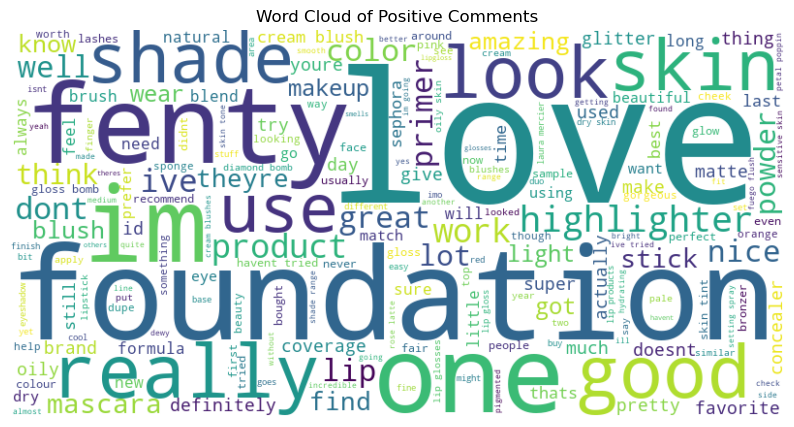

In [71]:
# Word cloud for positive comments
positive_text = ' '.join(df[df['transformer_sentiment'] == 'POSITIVE']['comment'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Comments')
plt.show()


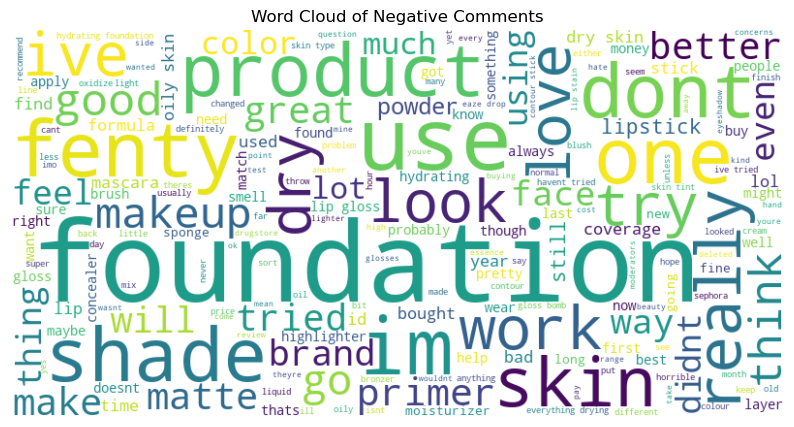

In [72]:
# Word cloud for negative comments
negative_text = ' '.join(df[df['transformer_sentiment'] == 'NEGATIVE']['comment'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Comments')
plt.show()


In [73]:
# Sample positive comments
print("Examples of Positive Comments:")
print(df[df['transformer_sentiment'] == 'POSITIVE']['comment'].head(3), "\n")

# Sample neutral comments, if any exist
print("Examples of Neutral Comments:")
print(df[df['transformer_sentiment'] == 'NEUTRAL']['comment'].head(3), "\n")

# Sample negative comments
print("Examples of Negative Comments:")
print(df[df['transformer_sentiment'] == 'NEGATIVE']['comment'].head(3), "\n")


Examples of Positive Comments:
2     appropriately hyped imo i know so many people ...
4     the eyeliners suck for me slightly hooded and ...
12    i love the lip glosses and highlighters the ot...
Name: comment, dtype: object 

Examples of Neutral Comments:
Series([], Name: comment, dtype: object) 

Examples of Negative Comments:
0    i find their foundations too orange for me and...
1               a nightmare for dry and sensitive skin
3    not great dont like the gloss matte foundation...
Name: comment, dtype: object 



### Sentiment Analysis Report on Fenty Beauty Reviews Using DistilBERT

#### Overview

In this report, we explore customer sentiment toward Fenty Beauty products using DistilBERT, a transformer-based model. DistilBERT is well-suited for analyzing product reviews because it understands context and can capture nuanced opinions, which is essential for interpreting complex feedback often found in beauty reviews. This analysis categorizes each comment as either **Positive** or **Negative** based on the model's interpretation of the text, with scores indicating the model’s confidence level.

#### Key Findings

##### Sentiment Breakdown

The results show a nearly even split in sentiment: **52% of comments** were classified as **Negative**, while **48% were Positive**. This balanced distribution suggests a **polarized perception** of Fenty Beauty products, with users almost equally divided between appreciation and criticism. While this indicates that many customers are happy with their purchases, a substantial number express dissatisfaction.

##### Confidence in Classifications

DistilBERT demonstrated high confidence in its classifications, as most sentiment scores were close to 1.0. This trend reflects that users were often clear in their praise or criticism. The model’s ability to assign high confidence scores in such cases is valuable for understanding strong opinions, though it may occasionally oversimplify comments with mixed sentiments.

#### Common Themes in Positive and Negative Feedback

##### Positive Sentiment

In the positive comments, the words “love,” “good,” “shade,” and “foundation” appear frequently. This feedback highlights two major strengths of Fenty Beauty: its inclusive **shade range** and popular products like foundations and lip glosses. Many customers expressed that Fenty’s range of shades allowed them to find a match they couldn't find with other brands, underscoring the brand’s appeal for diversity and inclusion.

For example, one user said, “I love the lip glosses and highlighters. The other products are good, too!” Another mentioned, “Appropriately hyped imo, I know so many people who could not find their shade until Fenty released.” These comments emphasize that Fenty has made a positive impact by filling a gap in the market and offering products that resonate with customers on a personal level.

##### Negative Sentiment

In contrast, negative comments frequently mention words like “foundation,” “dry,” “skin,” and “orange.” This suggests that while Fenty’s shade range is appreciated, there are issues with the formulation of some products, particularly foundations. Complaints often revolve around shades being too orange or drying out the skin. For instance, one user noted, “I find their foundations too orange for me and they oxidize a lot unfortunately.” Another mentioned, “A nightmare for dry and sensitive skin.”

These insights suggest potential areas for improvement. Foundations seem to be a particular pain point, with customers mentioning issues like oxidation (when foundation changes color after application, usually turning orange) and incompatibility with certain skin types. Packaging issues were also occasionally noted, though they were less frequent.

#### Interpretation

The DistilBERT analysis reveals a **polarized view** of Fenty Beauty. The brand’s strong suit is its commitment to inclusivity, as reflected in the positive comments about shade variety and quality. This aspect of Fenty’s offerings resonates strongly with customers who feel that their unique skin tones are finally being represented. However, the **negative feedback** suggests that Fenty may need to address certain product formulation issues, especially with foundations. Customers with sensitive or dry skin seem to experience more challenges, and the brand might benefit from offering more skin-friendly options.

#### Model Evaluation and Limitations

DistilBERT proved to be a valuable tool for this analysis, especially in its ability to understand and categorize context-rich language in reviews. Unlike simpler models, DistilBERT could interpret nuanced feedback, which is crucial when opinions are mixed or complex.

However, there are some limitations. Although DistilBERT is more advanced, it still occasionally struggles with comments that contain mixed sentiments, and it still has some mistakes such as putting "the eyeliners suck for me slightly hooded and" i the POSITIVE category. In such cases, the model might categorize the entire comment as positive or negative, missing the layered feedback. Additionally, while DistilBERT performed well overall, it lacks domain-specific training on beauty-related language, which could affect its understanding of industry terms like “oxidize.” 

Furthermore, DistilBERT's tendency to assign high confidence scores means that it may oversimplify some reviews, especially those that don’t fit neatly into positive or negative categories. For example, a review with both praise and critique might still be classified with high confidence as one or the other, which could obscure some subtlety in user feedback.

#### Conclusion

DistilBERT's sentiment analysis of Fenty Beauty reviews provides a clear view of the brand's strengths and weaknesses. The **positive sentiment** highlights Fenty’s success in offering inclusive, high-quality products that resonate with many customers. However, the **negative sentiment** points to specific areas for improvement, especially in foundation formulation and compatibility with sensitive or dry skin types.

Overall, DistilBERT offers a comprehensive understanding of customer feedback. While it handles context better than simpler models, there’s still room for improvement in recognizing mixed sentiments. Future analyses could be enhanced by fine-tuning the model on beauty-specific datasets to improve its understanding of industry language and nuanced user opinions.

This analysis shows that Fenty Beauty is generally well-received, but there are actionable insights for the brand to consider, especially for customers seeking more compatible foundation options.

### Model Performance and Critique: DistilBERT vs. VADER

Both **DistilBERT** and **VADER** offer insights into the sentiment expressed in Fenty Beauty reviews, but they differ significantly in their approach, capabilities, and limitations. Below is a comparison and critique of each model's performance in this analysis.

#### Strengths of DistilBERT

1. **Contextual Understanding**: DistilBERT, being a transformer-based model, captures the context of words within sentences. For example, it understands complex sentences and nuanced sentiment that might include mixed opinions, such as “I love the shade, but it makes my skin dry.” VADER struggles with this kind of complexity, often missing the sentiment split.
   
2. **More Nuanced Sentiment Detection**: DistilBERT can interpret subtle sentiments and better handle reviews that contain expressions of ambivalence or mixed emotions. This allows for a more accurate classification in comments that don’t express a clear-cut positive or negative sentiment, unlike VADER, which is heavily reliant on lexicon-based scoring and may miss these subtleties.

3. **Domain Flexibility**: As a general-purpose NLP model, DistilBERT is adaptable across domains, making it suitable for sentiment analysis in contexts like beauty, where domain-specific language may play a role (e.g., “oxidize” in makeup). However, it could benefit from fine-tuning on a beauty-specific dataset, which would further improve its domain understanding.

4. **High Confidence in Sentiment Classification**: The histogram of DistilBERT sentiment scores shows high confidence, with scores clustering around 1.0, indicating clear positive or negative sentiment detection. This is especially useful for business decisions where clear-cut sentiment interpretation is essential.

#### Limitations of DistilBERT

1. **Computationally Intensive**: DistilBERT requires more resources than VADER, both in terms of processing time and computational power. This makes it less practical for large-scale analysis without adequate hardware (e.g., GPUs). VADER, on the other hand, is lightweight and can process data much faster, making it ideal for real-time or large-scale applications.

2. **Handling of Long Texts**: DistilBERT has a 512-token limit, requiring truncation or text splitting for longer reviews. This can lead to a loss of information if important parts of a review are cut off, potentially affecting sentiment classification accuracy. VADER doesn’t have this restriction and can process longer texts more straightforwardly.

3. **Occasional Overconfidence in Label Assignment**: Transformer models like DistilBERT sometimes assign high confidence scores to labels, even in cases where the sentiment could be more nuanced or balanced. This can skew the sentiment distribution if the model over-represents strongly positive or negative classifications. VADER, by contrast, provides a compound score that reflects a more gradual interpretation of sentiment, which can be advantageous in cases where comments are more balanced.

#### VADER Strengths

1. **Efficiency and Speed**: VADER is extremely efficient and can quickly analyze large volumes of text without requiring significant computational resources. This makes it suitable for real-time sentiment analysis or when computational limitations are a concern.

2. **Handling of Industry-Specific Lexicons**: VADER includes a lexicon that’s somewhat tuned for social media language, which can be beneficial for interpreting common expressions and abbreviations found in online reviews. This makes it better suited for informal language than some general-purpose transformer models without fine-tuning.

3. **Clear, Gradual Sentiment Scoring**: VADER’s compound score (a continuous range between -1 and 1) provides a more nuanced look at the sentiment scale, which can be useful for interpreting reviews that aren’t strictly positive or negative. This is beneficial when there’s a need to gauge slight shifts in sentiment rather than binary classifications.

#### VADER Limitations

1. **Lexicon Dependency and Limited Contextual Understanding**: VADER relies on predefined word scores, so it struggles with nuanced language and phrases that require context for accurate interpretation. For example, it may not understand phrases like “I wanted to love it, but it didn’t work for me” as conveying mixed sentiment. DistilBERT, on the other hand, can better handle such sentences due to its contextual embeddings.

2. **Difficulty with Domain-Specific Terms**: VADER’s lexicon may lack beauty-specific terminology (e.g., “oxidize,” “undertone,” “dewy”), leading to misinterpretation or missed sentiment cues. DistilBERT, while not specifically trained on beauty language, has a broader understanding that can sometimes capture these terms more accurately, especially if fine-tuned.

3. **Simplicity of Scoring Mechanism**: VADER’s scoring method is effective for simple positive or negative sentiment, but it can be overly simplistic. It lacks the depth to detect complex sentiment patterns within the same review. DistilBERT provides a richer sentiment classification, especially when comments are complex or ambivalent.

#### Summary of Comparison

| Feature                 | DistilBERT                                 | VADER                                   |
|-------------------------|--------------------------------------------|-----------------------------------------|
| **Contextual Understanding** | Strong; can understand nuanced sentiments | Limited; relies on individual word scores |
| **Computational Requirements** | High; requires more resources          | Low; lightweight and fast               |
| **Handling Long Texts** | Limited to 512 tokens; needs truncation   | No limit, processes full text           |
| **Accuracy with Mixed Sentiment** | Better for mixed sentiments           | Struggles with complex expressions      |
| **Domain-Specific Language** | Moderate, can be improved with fine-tuning | Weak, limited to predefined lexicon     |
| **Suitability for Real-Time Analysis** | Moderate (requires GPUs for speed) | Excellent; fast processing              |

#### Overall Conclusion

DistilBERT provides a more **contextually aware and nuanced sentiment analysis** than VADER, which is useful for understanding subtle customer feedback in beauty reviews. However, VADER excels in **efficiency** and is effective for simpler sentiment tasks where computational resources are limited. 

If a project requires **speed and efficiency** without a need for highly nuanced understanding (e.g., large-scale social media monitoring), VADER is a good choice. For **in-depth sentiment analysis** where the context and complexity of language matter, especially in domains with mixed sentiments like product reviews, DistilBERT or similar transformer models are preferable. 

In the case of Fenty Beauty reviews, DistilBERT is a more suitable choice due to the nuanced feedback users provide on beauty products. However, combining insights from both models could offer a balanced approach, leveraging VADER’s speed for initial analysis and DistilBERT’s depth for detailed interpretation.